# 1D Unscented kalman filter
1次元でのUnscented kalman filterのサンプルです。  
# ライブラリのインポート

In [1]:
%matplotlib inline
import numpy as np
import math, random
import matplotlib.pyplot as plt

# ランドマーククラス
下のグラフに表示されている星です。  
ロボットはこの星を目印にして自分の位置を知ります。  
今回は星の位置もロボットが覚えている設定です。  

In [2]:
class Landmark:
    #目印となるランドマークの位置設定
    def __init__(self, pos):
        self.true_lx = pos
    
    #ランドマークの描画
    def draw(self):
        xs = self.true_lx
        ys = 1.0
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")

# ロボットクラス
ロボットは下のグラフの赤い矢印です。  

In [3]:
class Robot:
    def __init__(self, pos, v):
        #ロボットの初期位置
        self.true_x = pos
        
        #推定位置の初期位置
        self.mean_x = pos
        
        #推定位置の分散初期値
        self.v_x = v
        
        #パラメータ設定
        alpha = 1.1
        beta  = 2.0
        kappa = 0.0
        
        #次元の設定
        n     = 1.0
        
        #重み計算時に使用する
        lamda = alpha ** 2 * (n + kappa) - n
        print("lamda = " + str(lamda))
        
        #シグマポイント生成時に使用する
        self.gamma = math.sqrt(n + lamda)
        print("gamma = " + str(self.gamma))
        
        #シグマポイントの平均計算時の重み
        self.sp_wm0 = lamda / (n + lamda)
        self.sp_wm1 = 1 / (2 * (n + lamda))
        self.sp_wm2 = 1 / (2 * (n + lamda))
        print("sp_wm0 = " + str(self.sp_wm0))
        print("sp_wm1 = " + str(self.sp_wm1))
        print("sp_wm2 = " + str(self.sp_wm2))
        
        #シグマポイントの分散計算時の重み
        self.sp_wc0 = lamda / (n + lamda) + (1 - alpha ** 2 + beta)
        self.sp_wc1 = 1 / (2 * (n + lamda))
        self.sp_wc2 = 1 / (2 * (n + lamda))
        print("sp_wc0 = " + str(self.sp_wc0))
        print("sp_wc1 = " + str(self.sp_wc1))
        print("sp_wc2 = " + str(self.sp_wc2))
        
        # シグマポイントの生成
        self.sp_x0 = self.mean_x
        self.sp_x1 = self.mean_x + self.gamma * math.sqrt(self.v_x)
        self.sp_x2 = self.mean_x - self.gamma * math.sqrt(self.v_x)
        
    def move(self, fw):
        sigma_fw = fw * 0.3   #移動量の30%を標準偏差に設定
        v_fw = sigma_fw ** 2  #移動量の分散
        
        # ロボットの移動
        actual_fw = random.gauss(fw, sigma_fw)  #雑音の入った移動量の計算
        self.true_x = self.true_x + actual_fw   #ロボットの移動
        
        # シグマポイントの移動
        self.sp_x0 = self.sp_x0 + fw
        self.sp_x1 = self.sp_x1 + fw
        self.sp_x2 = self.sp_x2 + fw
        
        # シグマポイントから移動後の平均位置
        self.mean_x  = self.sp_wm0 * self.sp_x0
        self.mean_x += self.sp_wm1 * self.sp_x1
        self.mean_x += self.sp_wm2 * self.sp_x2
        
        # シグマポイントから移動後の位置の分散
        self.v_x  = self.sp_wc0 * (self.sp_x0 - self.mean_x) ** 2 + v_fw
        self.v_x += self.sp_wc1 * (self.sp_x1 - self.mean_x) ** 2 + v_fw
        self.v_x += self.sp_wc2 * (self.sp_x2 - self.mean_x) ** 2 + v_fw
        
        # 移動後のガウス分布によるシグマポイントの生成
        self.sp_x0 = self.mean_x
        self.sp_x1 = self.mean_x + self.gamma * math.sqrt(self.v_x)
        self.sp_x2 = self.mean_x - self.gamma * math.sqrt(self.v_x)
        
    def observation(self, landmark):
        # シグマポイントからの観測
        distance_0 = math.sqrt((self.sp_x0 - landmark.true_lx) ** 2)
        distance_1 = math.sqrt((self.sp_x1 - landmark.true_lx) ** 2)
        distance_2 = math.sqrt((self.sp_x2 - landmark.true_lx) ** 2)
        
        #距離の10%を標準偏差とした分散
        v_d0 = (distance_0 * 0.1) ** 2
        v_d1 = (distance_1 * 0.1) ** 2
        v_d2 = (distance_2 * 0.1) ** 2
        
        #シグマポイントにおける観測結果の保存
        self.sp_z0 = landmark.true_lx - distance_0
        self.sp_z1 = landmark.true_lx - distance_1
        self.sp_z2 = landmark.true_lx - distance_2
        
        # 観測結果の重み付き平均
        self.mean_z  = self.sp_wm0 * self.sp_z0
        self.mean_z += self.sp_wm1 * self.sp_z1
        self.mean_z += self.sp_wm2 * self.sp_z2
        
        # 観測結果の分散
        self.v_z  = self.sp_wc0 * (self.sp_z0 - self.mean_z) ** 2 + v_d0
        self.v_z += self.sp_wc1 * (self.sp_z1 - self.mean_z) ** 2 + v_d1
        self.v_z += self.sp_wc2 * (self.sp_z2 - self.mean_z) ** 2 + v_d2
        
        #ロボットにおける観測結果の保存
        distance = math.sqrt((self.true_x - landmark.true_lx) ** 2)
        self.sigma_z = distance * 0.1
        self.rz = landmark.true_lx - random.gauss(distance, self.sigma_z)
        
    def uncsented_kalman_filter(self):
        # シグマポイントにおける位置と観測結果の共分散
        v_xz  = self.sp_wc0 * (self.sp_x0 - self.mean_x) * (self.sp_z0 - self.mean_z)
        v_xz += self.sp_wc1 * (self.sp_x1 - self.mean_x) * (self.sp_z1 - self.mean_z)
        v_xz += self.sp_wc2 * (self.sp_x2 - self.mean_x) * (self.sp_z2 - self.mean_z)
        
        # カルマンゲイン生成
        kalman_gain = v_xz / self.v_z
        
        #推定自己位置のガウス分布を更新
        self.mean_x = self.mean_x + kalman_gain * (self.rz - self.mean_z)
        self.v_x = self.v_x - kalman_gain ** 2 * self.v_z
        
        # シグマポイントの更新
        self.sp_x0 = self.mean_x
        self.sp_x1 = self.mean_x + self.gamma * math.sqrt(self.v_x)
        self.sp_x2 = self.mean_x - self.gamma * math.sqrt(self.v_x)
        
    def draw(self, sp, i):
        # ロボットの描画
        xs  = self.true_x
        ys  = 1.0
        vxs = 1.0
        vys = 0.0
        plt.quiver(xs,ys,vxs,vys,color="red",label="actual robot pos")
        
        # シグマポイントの描画
        xs = [self.sp_x0, self.sp_x1,self.sp_x2]
        vxs = [1.0, 1.0, 1.0]
        ys  = 0.0
        plt.quiver(xs,ys,vxs,vys,color="orange",label="sigma points")
        
        if i > 0:
            x = np.arange(-0.5, 1.5, 0.0001)
            
            #移動前の推定位置の分布を描画
            bel_x = np.exp(-(self.mean_x - x) ** 2 / (2 * self.v_x)) / np.sqrt(2 * np.pi * self.v_x)
            #移動後の推定位置の分布を描画
            #am_bel_x = np.exp(-(self.am_bel_x - x) ** 2 / (2 * (self.am_sigma_x ** 2))) / (self.am_sigma_x * np.sqrt(2 * np.pi))
            #観測結果の分布を描画
            #z        = np.exp(-(self.z - x) ** 2 / (2 * (self.sigma_z ** 2))) / (self.sigma_z * np.sqrt(2 * np.pi))
            
            plt.plot(x, bel_x, color = "orange",label="bel_x")
            #plt.plot(x, am_bel_x, color = "green",label="am_bel_x")
            #plt.plot(x, z       , color = "blue",label="z")

        plt.legend()

# 描画関数

In [4]:
def draw(i):
    #グラフの設定
    fig = plt.figure(i, figsize=(14,6))
    sp = fig.add_subplot(111)
    sp.set_xlim(-0.25,1.25)
    sp.set_ylim(-0.1,15)
    
    # パーティクル、ロボット、ランドマークの描画
    robot.draw(sp, i)
    landmark.draw()
        
    plt.legend()

# シミュレーション開始
ロボットが移動、観測、フィルタリングを繰り返します。

lamda = 0.2100000000000002
gamma = 1.1
sp_wm0 = 0.17355371900826458
sp_wm1 = 0.4132231404958677
sp_wm2 = 0.4132231404958677
sp_wc0 = 1.9635537190082644
sp_wc1 = 0.4132231404958677
sp_wc2 = 0.4132231404958677


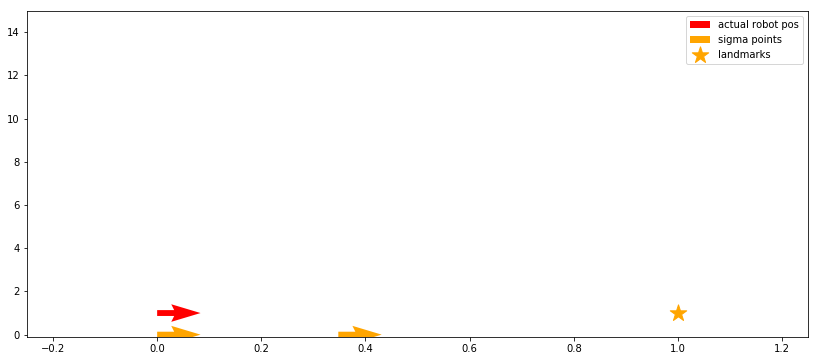

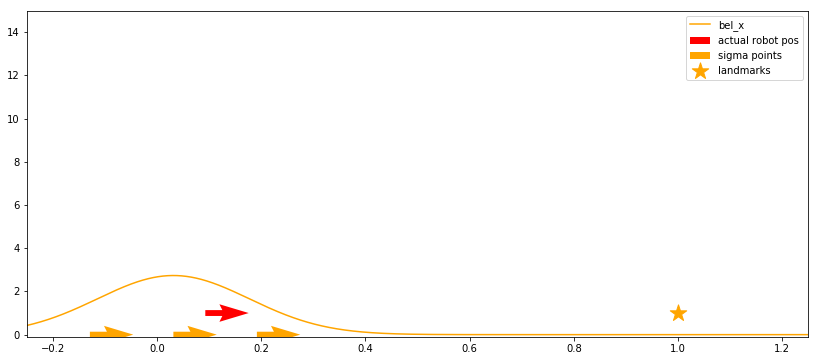

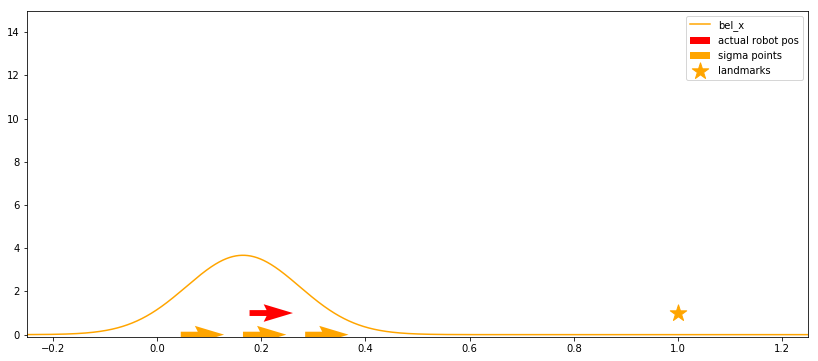

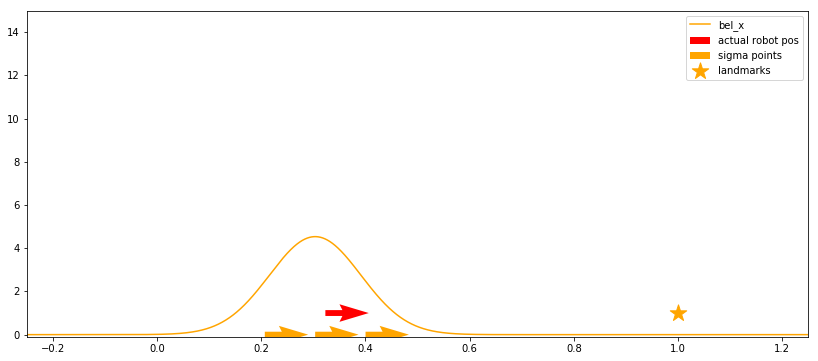

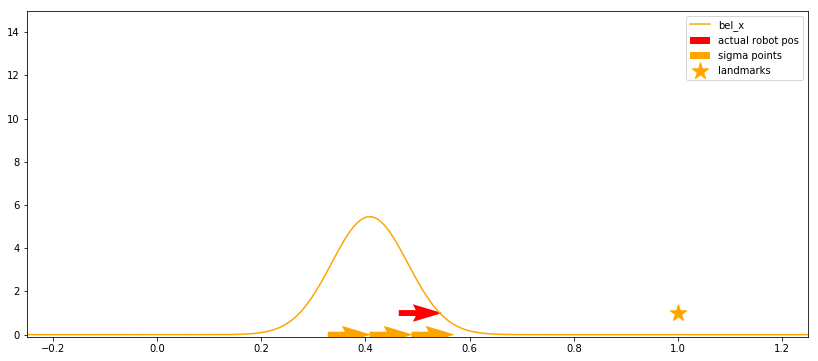

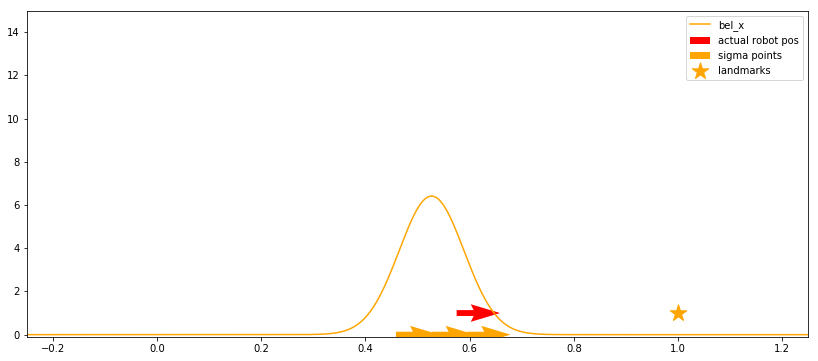

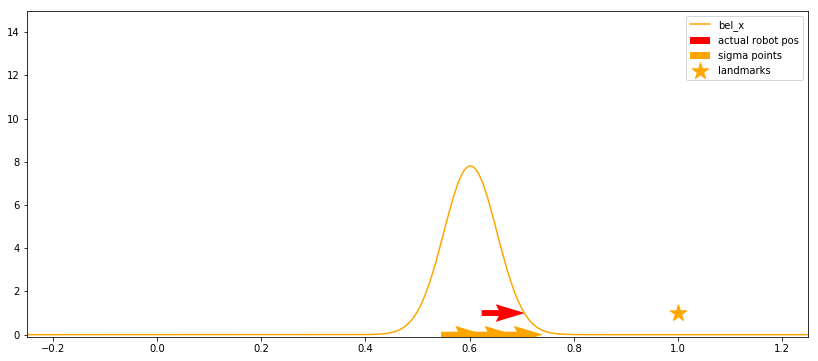

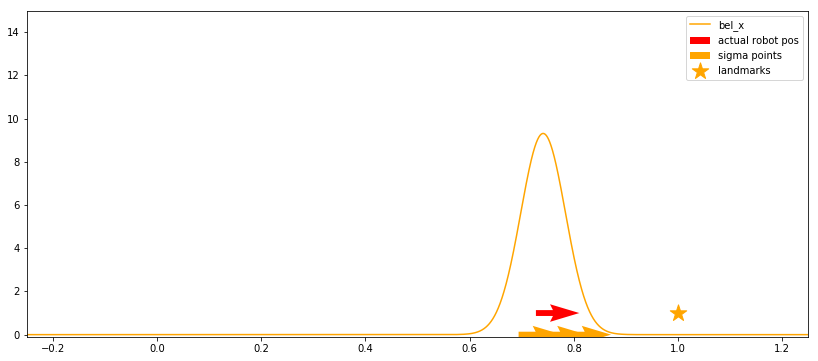

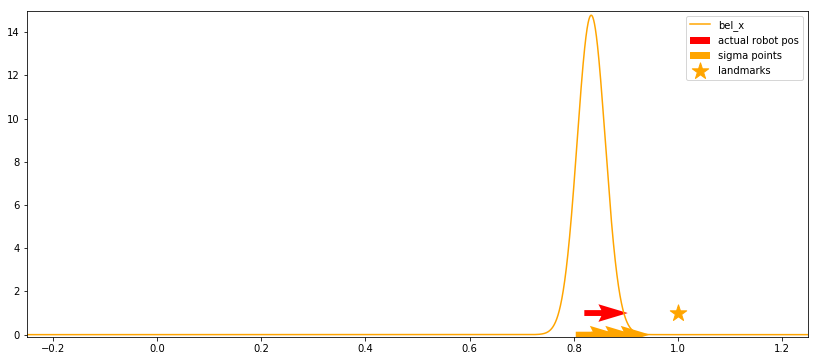

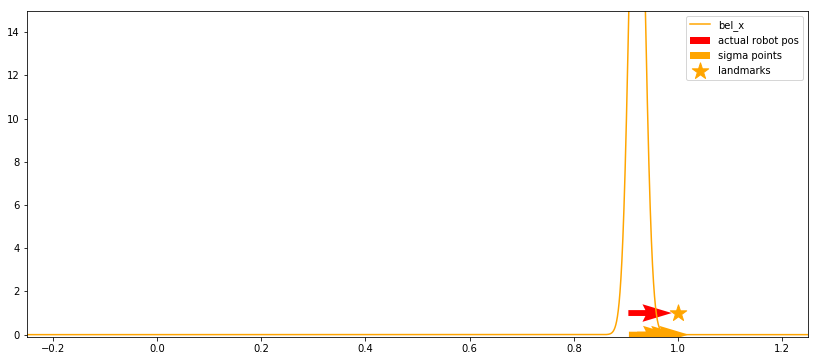

In [5]:
robot = Robot(0.0, 0.1)   #ロボットの移動
landmark = Landmark(1.0)  #ランドマークの設置
draw(0)
for i in range(1, 10):
    robot.move(0.1)                  #ロボットの移動
    robot.observation(landmark)      #ロボットの観測
    robot.uncsented_kalman_filter()  #アンセンテッドカルマンフィルタ
    draw(i)                          #描画